<a href="https://colab.research.google.com/github/aaronhallaert/DeepLearningLab/blob/main/Third%20Graded%20Assignment/GA3_Final_model_Windowed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GA3 Model 3: Window-based
Now use all available information to build good time series models (using current values and histories of multiple features). Explore both, window-based and recurrent model types (cf. slides for additional instructions).

## Imports and drive mounting

In [1]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn as sk
import pandas as pd
from pandas import read_csv
from datetime import datetime
import math
import os

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.losses import MAE
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

2.4.1


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
def PlotResults(labels,predictions,binsize = 10):
  num_samples = len(labels)
  
  fig = plt.figure(figsize=(16,16))
  spec = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)
  ax1 = fig.add_subplot(spec[0, :])
  ax2 = fig.add_subplot(spec[1, :])
  ax3 = fig.add_subplot(spec[2:,0:2])
  ax4 = fig.add_subplot(spec[2:,2:])
  
  ax1.plot(labels,'k-',label='Labels')
  ax1.plot(predictions,'r-',label='Predictions')
  ax1.set_ylabel('Pollution')
  ax1.legend()
  
  errors=np.absolute(labels-predictions)
  ax2.plot(errors,'k-')
  ax2.set_ylabel("Absolute error")
  
  ax3.scatter(labels,predictions)
  ax3.set_xlabel('Labels')
  ax3.set_ylabel('Predictions')

  bins = np.arange(0,(np.ceil(np.max(errors)/binsize)+1)*binsize,binsize)
  
  ax4.hist(errors,bins=bins)
  ax4.set_xlabel('Absolute error')
  ax4.set_ylabel('Frequency')

  plt.show()

def plot_history(history):
  plt.figure(figsize = (6,4))
  
  plt.xlabel('Epoch')
  plt.ylabel('Mae')
  plt.plot(history.epoch, np.array(history.history['mae']),'g-',
           label='Train MAE')
  plt.plot(history.epoch, np.array(history.history['val_mae']),'r-',
           label = 'Validation MAE')
  plt.legend()
  plt.show()

# window-based and recurrent networks:
# now, you use a window of k history values to predict
# this means that the features of the first k timesteps (indices 0 to k-1)
# are used to predict the k+3rd pollution value (index k+3-1)
# output dimension of train data is samples x window x features

def create_dataset_windowed(train, test, ahead=3, window_size=1):
  samples = train.shape[0]-ahead-(window_size-1) 
  dataX= []
  for i in range(samples):
      a = train[i:(i+window_size), :]
      dataX.append(a)
  return np.array(dataX), test[ahead+window_size-1:]

In [4]:
DATAPATH = '/content/gdrive/My Drive/Colab Notebooks/DL2021/'  
TRAINDATAFILE = DATAPATH+'preprocessed_train_data.csv'
VALDATAFILE = DATAPATH+'preprocessed_val_data.csv'
TESTDATAFILE = DATAPATH+'preprocessed_test_data.csv'

train_dataset = read_csv(TRAINDATAFILE, header=0, index_col=0)
val_dataset = read_csv(VALDATAFILE, header=0, index_col=0)
test_dataset = read_csv(TESTDATAFILE, header=0, index_col=0)

In [5]:
# 0: year (default not used)
# 1: month (default not used)
# 2: day (default not used)
# 3: hour (default not used)
# 4: pollution
# 5: dew
# 6: temp
# 7: press
# 8: wind_dir (default not used)
# 9: wind_speed (default not used)
# 10: snow (default not used)
# 11: rain
# 12: cos
# 13: sin
# 14: weekdays
# 15: NE_strength
# 16: NW_strength
# 17: NS_strength (default not used)
# 18: cv_strength (default not used)

features = [4,5,6,7,11,12,13,14,15,16]
pollution = 4

train_values = np.asarray(train_dataset.values[:,features],dtype=np.float32)
train_labels = np.asarray(train_dataset.values[:,pollution],dtype=np.float32)
val_values = np.asarray(val_dataset.values[:,features],dtype=np.float32)
val_labels = np.asarray(val_dataset.values[:,pollution],dtype=np.float32)

train_all_values = np.concatenate((train_values,val_values))
train_all_labels = np.concatenate((train_labels,val_labels))

test_values = np.asarray(test_dataset.values[:,features],dtype=np.float32)
test_labels = np.asarray(test_dataset.values[:,pollution],dtype=np.float32)


print(train_values.shape)
print(train_labels.shape)
print(val_values.shape)
print(val_labels.shape)

print(train_all_values.shape)
print(train_all_labels.shape)

print(test_values.shape)
print(test_labels.shape)


(26280, 10)
(26280,)
(8760, 10)
(8760,)
(35040, 10)
(35040,)
(8760, 10)
(8760,)


In [6]:
# Scale the features 
# Look up and choose a scaler
# StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer

# Finally, you could also consider to start with a batchnorm layer to let your model fine-tune the feature scaling.

SS1 = StandardScaler()
SS1.fit(train_values)

train_scaled = SS1.transform(train_values)
val_scaled = SS1.transform(val_values)

SS2 = StandardScaler()
SS2.fit(train_all_values)

train_all_scaled = SS2.transform(train_all_values)
test_scaled = SS2.transform(test_values)

In [7]:
CNN_WINDOW_SIZE = 24

# current code for pollution-only, add other features for multi-feature model, 
# remove indices as in commented code if you want to use all features

# note that in the current feature set, pollution is the first feature (index=0)

# 0: pollution
# 1: dew
# 2: temp
# 3: press
# 4: rain
# 5: cos
# 6: sin
# 7: weekdays
# 8: NE_strength
# 9: NW_strength

train_features = [0,1,2,3,4,5,6,7,8,9] 

X_train_w,r_train_w = create_dataset_windowed(train_scaled[:,train_features],train_labels, window_size=CNN_WINDOW_SIZE)
X_val_w,r_val_w = create_dataset_windowed(val_scaled[:,train_features],val_labels, window_size=CNN_WINDOW_SIZE)

X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled[:,train_features],train_all_labels, window_size=CNN_WINDOW_SIZE)
X_test_w,r_test_w = create_dataset_windowed(test_scaled[:,train_features],test_labels, window_size=CNN_WINDOW_SIZE)


CNNmodel = Sequential()
CNNmodel.add(Conv1D(input_shape = (CNN_WINDOW_SIZE, X_train_w.shape[-1]), 
                        filters=32,
                        kernel_size=2,
                        padding='same',
                        activation='relu'))
CNNmodel.add(MaxPooling1D(pool_size=2))
CNNmodel.add(Conv1D(filters=16,
                        kernel_size=2,
                        padding='same',
                        activation='relu'))
CNNmodel.add(MaxPooling1D(pool_size=2))

CNNmodel.add(Flatten())
CNNmodel.add(Dense(1))
CNNmodel.add(Activation('linear'))

CNNmodel.summary()

CNNmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss='mae', metrics=['mae','mse'])

batch_size=64
epochs=10
CNN_history = CNNmodel.fit(X_train_w, r_train_w, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_w, r_val_w),
          shuffle=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 24, 32)            672       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 16)            1040      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 97        
_________________________________________________________________
activation (Activation)      (None, 1)                 0

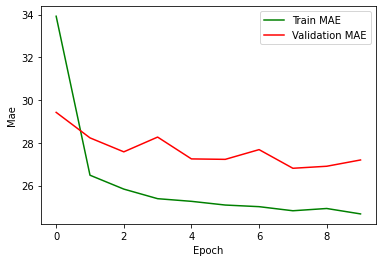

In [8]:
plot_history(CNN_history)

"Final model windowed":
 train mae =  24.73501 
 validation mae =  27.196653
(26254, 1)
(8734, 1)


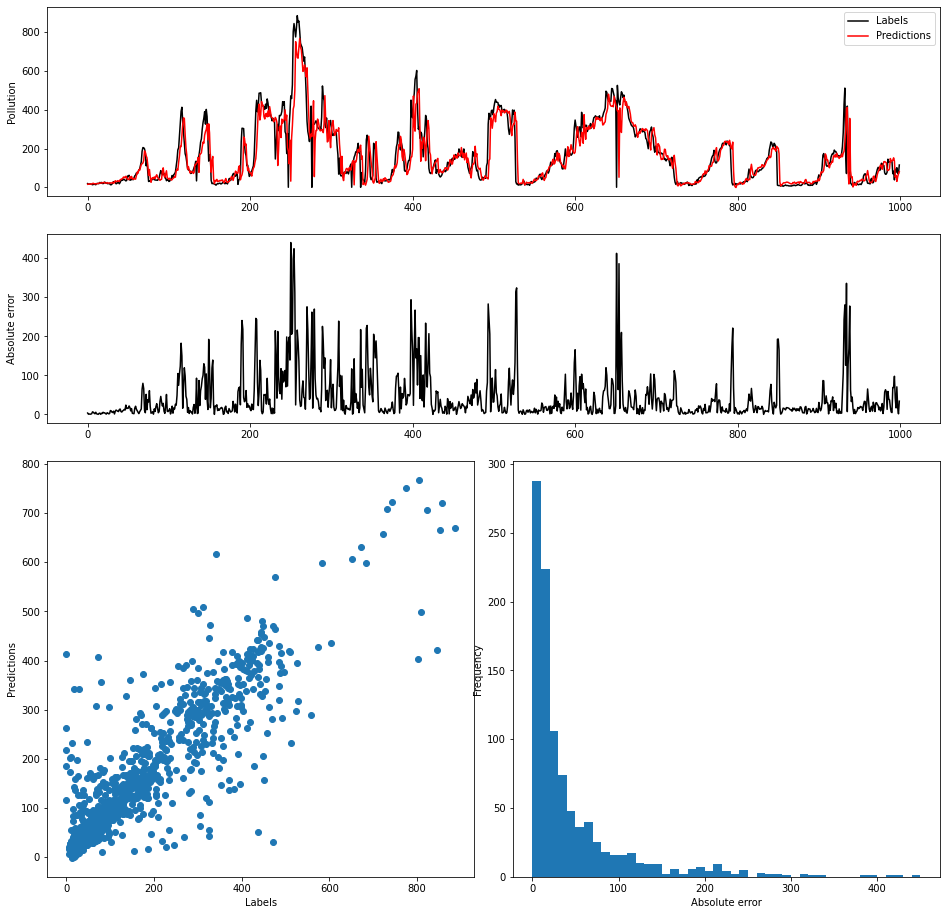

In [9]:
y_train_CNNmodel = CNNmodel.predict(X_train_w)
y_val_CNNmodel = CNNmodel.predict(X_val_w)

mae_train_CNNmodel = mean_absolute_error(r_train_w,y_train_CNNmodel)
mae_val_CNNmodel = mean_absolute_error(r_val_w,y_val_CNNmodel)

print("\"Final model windowed\":\n train mae = ",mae_train_CNNmodel,
      "\n validation mae = ",mae_val_CNNmodel)

print(y_train_CNNmodel.shape)
print(y_val_CNNmodel.shape)

# Visualise first 1000 predictions for validation
PlotResults(r_val_w[:1000],y_val_CNNmodel[:1000,0])